In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [8]:
columns = ['activity', 'timestamp', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
df = pd.read_csv('data/myo/myo_data.csv', header = None, names = columns)
df = df.dropna()

In [9]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

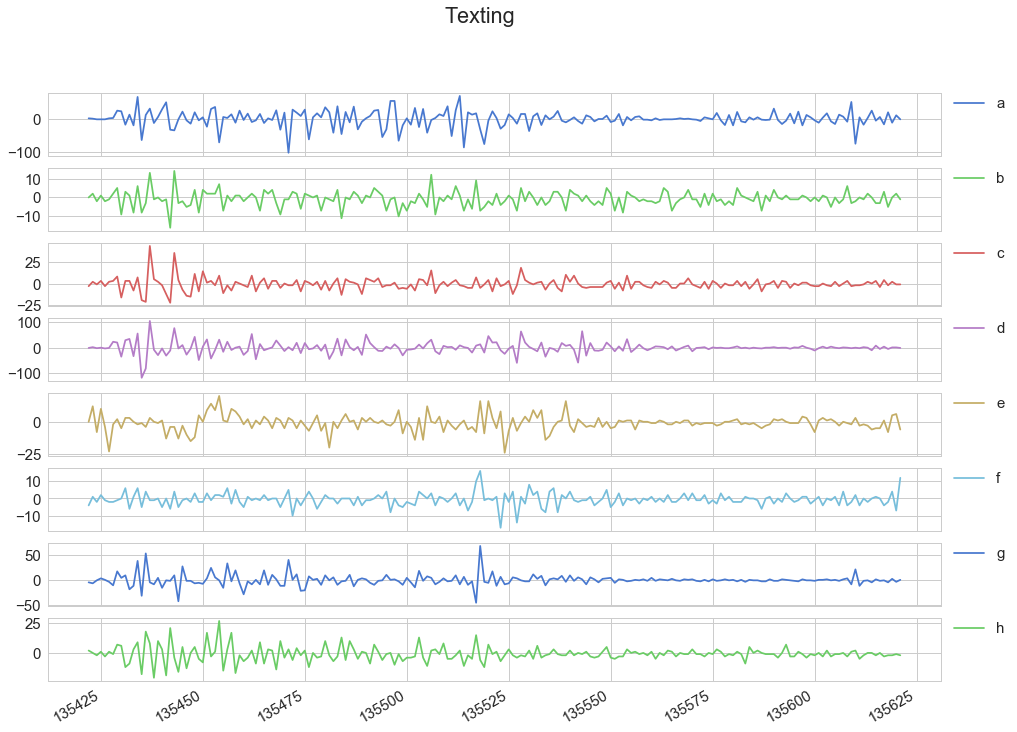

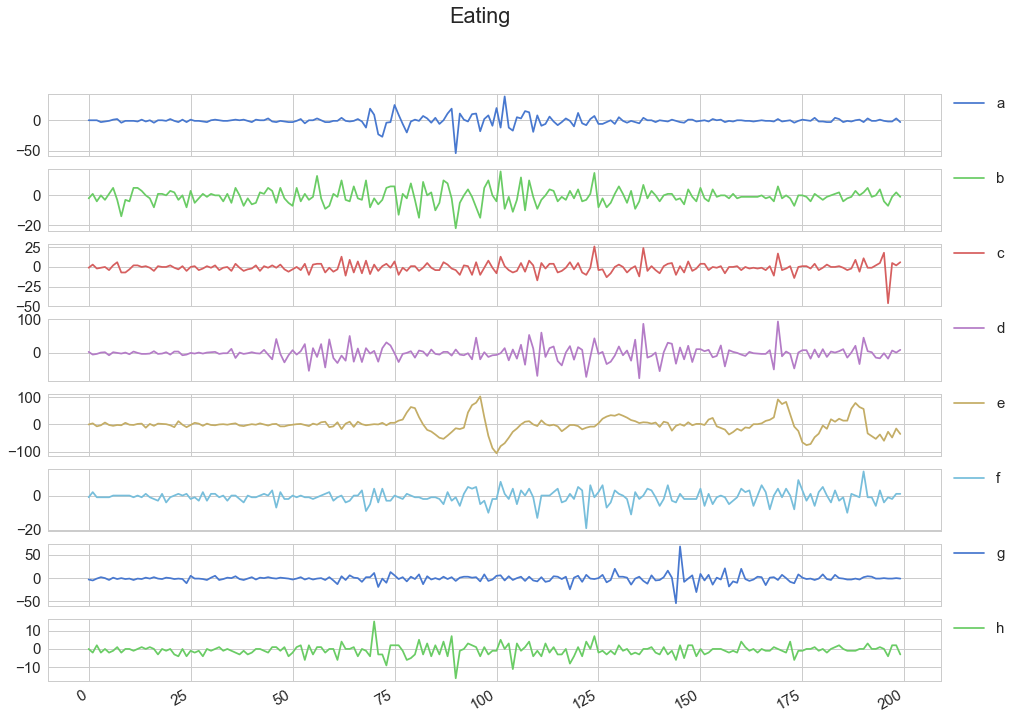

In [10]:
plot_activity('Texting', df)
plot_activity('Eating', df)

In [11]:
N_TIME_STEPS = 200
N_FEATURES = 8
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    a = df['a'].values[i: i + N_TIME_STEPS]
    b = df['b'].values[i: i + N_TIME_STEPS]
    c = df['c'].values[i: i + N_TIME_STEPS]
    d = df['d'].values[i: i + N_TIME_STEPS]
    e = df['e'].values[i: i + N_TIME_STEPS]
    f = df['f'].values[i: i + N_TIME_STEPS]
    g = df['g'].values[i: i + N_TIME_STEPS]
    h = df['h'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([a, b, c, d, e, f, g, h])
    labels.append(label)

In [12]:
np.array(segments).shape

(11883, 8, 200)

In [13]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [15]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [16]:
def create_model(inputs):
    weights = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, weights['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, weights['output']) + biases['output']

In [17]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [18]:
predicted_y = create_model(X)

prediction_softmax = tf.nn.softmax(predicted_y, name="y_")

In [19]:
L2_LOSS = 0.0015

l2 = L2_LOSS * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predicted_y, labels=Y)) + l2


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [20]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_prediction = tf.equal(tf.argmax(prediction_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))

In [21]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([prediction_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([prediction_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print('Epoch: ' + str(i) + ', Training Accuracy: ' + str(acc_train) + ', Test Accuracy: ' + str(acc_test))


Epoch: 1, Training Accuracy: 0.6959815, Test Accuracy: 0.686159
Epoch: 10, Training Accuracy: 0.9203661, Test Accuracy: 0.9019773
Epoch: 20, Training Accuracy: 0.96013045, Test Accuracy: 0.9360539
Epoch: 30, Training Accuracy: 0.89901114, Test Accuracy: 0.889777


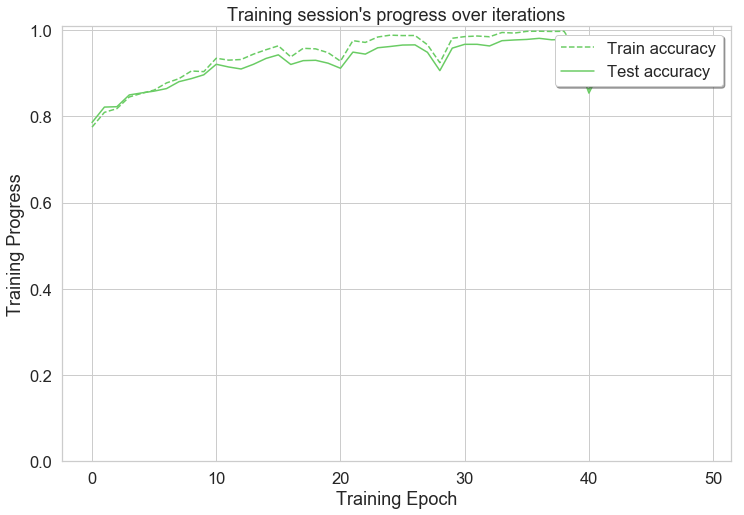

In [41]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()